# Feature Engineering

Feature engineering involves creating new features or transforming existing features to provide additional information to the model for better predictions.
In our case, besides the TMDB popularity scores we're going to use IMDB_votes as a feature that could improve the accuracy of our classification model.

In [2]:
import numpy as np
import pandas as pd

In [3]:
import os

In [10]:
titles = pd.read_csv('../../preprocessing/titles_preprocessed.csv')
credits = pd.read_csv('../../preprocessing/credits_preprocessed.csv')

In [7]:
titles.head()

,id,title,type,description,release_year,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity
0,tm19248,The General,MOVIE,"During America’s Civil War, Union spies steal ...",1926,78,"['action', 'drama', 'war', 'western', 'comedy'...",['US'],0.0,tt0017925,8.2,89766.0,8.647
1,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940,92,"['comedy', 'drama', 'romance']",['US'],0.0,tt0032599,7.8,57835.0,11.270
2,tm19424,Detour,MOVIE,"The life of Al Roberts, a pianist in a New Yor...",1945,66,"['thriller', 'drama', 'crime']",['US'],0.0,tt0037638,7.3,17233.0,7.757
3,tm112005,Marihuana,MOVIE,A young girl named Burma attends a beach party...,1936,57,"['crime', 'drama']",['US'],0.0,tt0026683,4.0,864.0,3.748
4,tm22806,Intolerance: Love's Struggle Throughout the Ages,MOVIE,"The story of a poor young woman, separated by ...",1916,197,"['history', 'drama']",['US'],0.0,tt0006864,7.7,15242.0,9.412


In [18]:
# Preprocessing the data

# Merge the titles with the actors/directors dataset
merged_titles_credits = pd.merge(credits, titles, on='id', how='left')

# Calculating the average IMDb vote and average TMDB popularity for each person_id
merged = merged_titles_credits.groupby('person_id').agg({'imdb_score': 'mean', 'imdb_votes': 'mean', 'tmdb_popularity': 'mean'}).reset_index()
merged.rename(columns={'imdb_score': 'average_imdb_score' , 'imdb_votes': 'average_imdb_votes', 'tmdb_popularity': 'average_tmdb_popularity'}, inplace=True)

# Drop rows with missing average IMDb scores or TMDB popularity
merged.dropna(subset=['average_imdb_score', 'average_imdb_votes', 'average_tmdb_popularity'], inplace=True)

In [19]:
# IMDB score bins (0-4 - Low, 4-7 - Medium, 7-10 - High)
bins = [0, 4, 7, 10]
# Class labels
labels = ['Low-Rated', 'Medium-Rated', 'High-Rated']  

# Bin the IMDb scores into different ranges and assign labels
merged['imdb_score_bin'] = pd.cut(merged['average_imdb_score'], bins=bins, labels=labels)

merged

,person_id,average_imdb_score,average_imdb_votes,average_tmdb_popularity,imdb_score_bin
1,45,4.866667,27721.666667,13.953333,Medium-Rated
2,46,5.833333,1599.444444,2.356111,Medium-Rated
3,48,5.766667,40435.333333,20.512333,Medium-Rated
4,49,5.400000,782.000000,2.990000,Medium-Rated
5,50,7.600000,131274.000000,41.570000,High-Rated
...,...,...,...,...,...
27347,2355758,6.700000,7536.000000,22.633000,Medium-Rated
27348,2360590,6.800000,2635.000000,11.905000,Medium-Rated
27349,2364670,8.200000,14763.000000,23.972000,High-Rated
27351,2369958,6.500000,23688.000000,707.594000,Medium-Rated


In [24]:
from sklearn.model_selection import train_test_split

# Split the dataset into features and target
X = merged[['average_imdb_votes', 'average_tmdb_popularity']] # Features: TMDB popularity
Y = merged['imdb_score_bin'] # Target: IMDb score bin from merged dataset

# Splitting the data into testing and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=41)

In [25]:
X_train

,average_imdb_votes,average_tmdb_popularity
20376,3582.0,6.242
23164,313427.0,45.706
15818,400.0,8.484
19850,335.0,1.256
16218,216.0,1.738
...,...,...
8591,2235.0,5.685
21853,44.0,1.251
20702,15242.0,9.412
937,138.0,2.528


In [43]:
# Normalizing TMDB popularity scores and IMDB votes
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
X_train

array([[1.79309719e-03, 1.23226517e-03],
       [1.57135527e-01, 9.85156905e-03],
       [1.97784661e-04, 1.72193878e-03],
       ...,
       [7.63889986e-03, 1.92462259e-03],
       [6.64295758e-05, 4.21093095e-04],
       [2.40259732e-01, 1.04901978e-02]])

In [51]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report
from termcolor import colored

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred, zero_division=True))

In [52]:
# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Train the KNN classifier
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [53]:
# Predicting results 
Y_pred = knn.predict(X_test)

# Evaluating the KNN model
report(knn, X_train, Y_train)

Classification report for model KNeighborsClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.92      0.91      0.91      4242
   Low-Rated       0.89      0.94      0.91      1018
Medium-Rated       0.97      0.97      0.97     14957

    accuracy                           0.96     20217
   macro avg       0.93      0.94      0.93     20217
weighted avg       0.96      0.96      0.96     20217



### Classification report - train set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 92% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 97% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 89% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 91% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 97% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 94% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.91
* **Medium-Rated class** - 0.97
* **Low-Rated class** - 0.91

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 4242
* **Medium-Rated class** - 1018
* **Low-Rated class** - 14957


### <u> Accuracy: 96% </u>

In [55]:
report(knn, X_test, Y_test, "test")

Classification report for model KNeighborsClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.88      0.87      0.87      1412
   Low-Rated       0.84      0.93      0.88       321
Medium-Rated       0.96      0.96      0.96      5006

    accuracy                           0.94      6739
   macro avg       0.89      0.92      0.90      6739
weighted avg       0.94      0.94      0.94      6739



### Classification report - test set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 88% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 96% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 84% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 87% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 96% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 93% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.87
* **Medium-Rated class** - 0.96
* **Low-Rated class** - 0.88

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 1412
* **Medium-Rated class** - 5006
* **Low-Rated class** - 321


### <u> Accuracy: 94% </u>

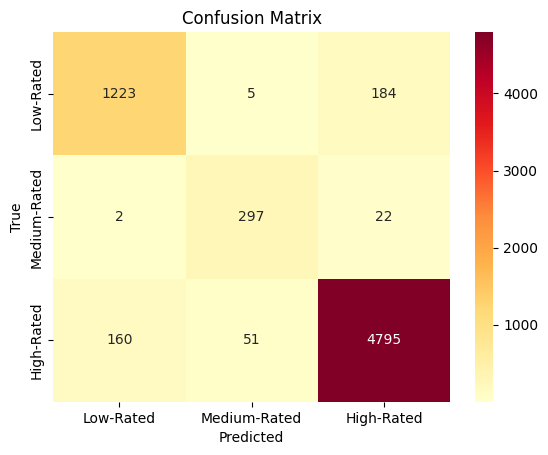

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [58]:
cm

array([[1223,    5,  184],
       [   2,  297,   22],
       [ 160,   51, 4795]], dtype=int64)

### Confusion matrix

##### For the Low-Rated class:
* 1223 samples were correctly predicted as Low-Rated
* 5 samples were predicted as Medium-Rated but were actually Low-Rated
* 184 samples were predicted as High-Rated but were actually Low-Rated

##### For the Medium-Rated class:
* 2 samples were predicted as Low-Rated but were actually Medium-Rated
* 297 samples were correctly predicted as Medium-Rated 
* 22 samples were predicted as High-Rated but were actually Medium-Rated 

##### For the High-Rated class:
* 160 samples were predicted as Low-Rated but were actually High-Rated
* 51 samples were predicted as Medium-Rated but were actually High-Rated
* 4795 samples were correctly predicted as High-Rated


In [60]:
# gini: measures impurity by calculating the probability of misclassifying a randomly chosen data point in that node
# entropy: measures impurity by calculating the entropy of the class
# This model will try both criterions to decide on how to split the decision tree

# The grid search will also try different values of the maximum depth of the decision tree (2, 4, 6, 8)
params = {'criterion': ['gini', 'entropy'], 
          'max_depth': [2, 4, 6, 8]
         }

params_grid = {'n_neighbors': range(10, 50, 5),
               'weights': ['uniform', 'distance'],
                'p': [1, 2]}

In [61]:
from sklearn.model_selection import GridSearchCV

estimator = GridSearchCV(KNeighborsClassifier(), params_grid, cv=6, verbose=4)
estimator.fit(X_train, Y_train)

Fitting 6 folds for each of 32 candidates, totalling 192 fits
[CV 1/6] END n_neighbors=10, p=1, weights=uniform;, score=0.893 total time=   0.0s
[CV 2/6] END n_neighbors=10, p=1, weights=uniform;, score=0.900 total time=   0.0s
[CV 3/6] END n_neighbors=10, p=1, weights=uniform;, score=0.896 total time=   0.0s
[CV 4/6] END n_neighbors=10, p=1, weights=uniform;, score=0.891 total time=   0.0s
[CV 5/6] END n_neighbors=10, p=1, weights=uniform;, score=0.907 total time=   0.0s
[CV 6/6] END n_neighbors=10, p=1, weights=uniform;, score=0.899 total time=   0.0s
[CV 1/6] END n_neighbors=10, p=1, weights=distance;, score=0.950 total time=   0.0s
[CV 2/6] END n_neighbors=10, p=1, weights=distance;, score=0.955 total time=   0.0s
[CV 3/6] END n_neighbors=10, p=1, weights=distance;, score=0.949 total time=   0.0s
[CV 4/6] END n_neighbors=10, p=1, weights=distance;, score=0.957 total time=   0.0s
[CV 5/6] END n_neighbors=10, p=1, weights=distance;, score=0.955 total time=   0.0s
[CV 6/6] END n_neigh

[CV 4/6] END n_neighbors=30, p=1, weights=uniform;, score=0.848 total time=   0.0s
[CV 5/6] END n_neighbors=30, p=1, weights=uniform;, score=0.852 total time=   0.0s
[CV 6/6] END n_neighbors=30, p=1, weights=uniform;, score=0.842 total time=   0.0s
[CV 1/6] END n_neighbors=30, p=1, weights=distance;, score=0.955 total time=   0.0s
[CV 2/6] END n_neighbors=30, p=1, weights=distance;, score=0.962 total time=   0.0s
[CV 3/6] END n_neighbors=30, p=1, weights=distance;, score=0.956 total time=   0.0s
[CV 4/6] END n_neighbors=30, p=1, weights=distance;, score=0.960 total time=   0.0s
[CV 5/6] END n_neighbors=30, p=1, weights=distance;, score=0.962 total time=   0.0s
[CV 6/6] END n_neighbors=30, p=1, weights=distance;, score=0.960 total time=   0.0s
[CV 1/6] END n_neighbors=30, p=2, weights=uniform;, score=0.845 total time=   0.0s
[CV 2/6] END n_neighbors=30, p=2, weights=uniform;, score=0.849 total time=   0.0s
[CV 3/6] END n_neighbors=30, p=2, weights=uniform;, score=0.846 total time=   0.0

GridSearchCV(cv=6, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(10, 50, 5), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [62]:
Y_pred = estimator.predict(X_test)

In [63]:
# Let's see what the best parameters are based on the estimator:

estimator.best_params_

{'n_neighbors': 45, 'p': 2, 'weights': 'distance'}

In [64]:
estimator.best_score_

0.9609241942080274

In [65]:
report(estimator.best_estimator_, X_train, Y_train)

Classification report for model KNeighborsClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       1.00      1.00      1.00      4242
   Low-Rated       1.00      1.00      1.00      1018
Medium-Rated       1.00      1.00      1.00     14957

    accuracy                           1.00     20217
   macro avg       1.00      1.00      1.00     20217
weighted avg       1.00      1.00      1.00     20217



In [66]:
report(estimator.best_estimator_, X_test, Y_test, "test")

Classification report for model KNeighborsClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.92      0.92      0.92      1412
   Low-Rated       0.97      0.94      0.95       321
Medium-Rated       0.97      0.98      0.97      5006

    accuracy                           0.96      6739
   macro avg       0.95      0.95      0.95      6739
weighted avg       0.96      0.96      0.96      6739



### Classification report - test set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 92% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 97% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 97% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 92% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 98% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 94% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.92
* **Medium-Rated class** - 0.97
* **Low-Rated class** - 0.95

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 1412
* **Medium-Rated class** - 5006
* **Low-Rated class** - 321


### <u> Accuracy: 96% </u>

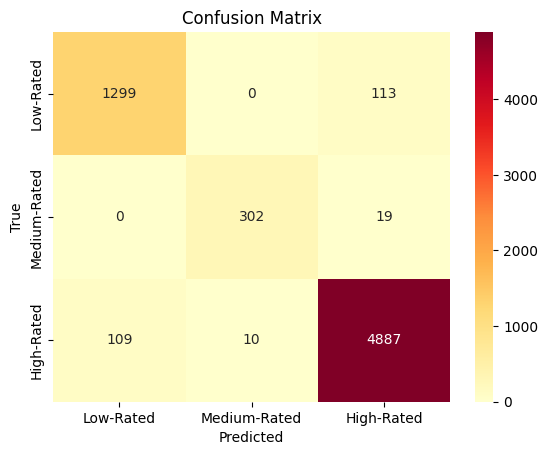

In [68]:
# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Confusion matrix

##### For the Low-Rated class:
* 1299 samples were correctly predicted as Low-Rated
* 0 samples were predicted as Medium-Rated but were actually Low-Rated
* 113 samples were predicted as High-Rated but were actually Low-Rated

##### For the Medium-Rated class:
* 0 samples were predicted as Low-Rated but were actually Medium-Rated
* 302 samples were correctly predicted as Medium-Rated 
* 19 samples were predicted as High-Rated but were actually Medium-Rated 

##### For the High-Rated class:
* 109 samples were predicted as Low-Rated but were actually High-Rated
* 10 samples were predicted as Medium-Rated but were actually High-Rated
* 4887 samples were correctly predicted as High-Rated
